In [1]:
import requests
from tqdm import tqdm

# URL of the image
url = "https://img.freepik.com/premium-photo/futuristic-cityscape-sunset-with-neon-lights_14117-901468.jpg"

# Download the image with progress bar
response = requests.get(url, stream=True)
response.raise_for_status()

# Get file size for progress bar (if available)
file_size = int(response.headers.get("content-length", 0))

# Write the file
with open("sample_image.jpg", "wb") as file:
    if file_size:
        with tqdm(
            total=file_size, unit="B", unit_scale=True, desc="Downloading"
        ) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
                pbar.update(len(chunk))
    else:
        file.write(response.content)

print("Image downloaded successfully as 'sample_image.jpg'")

Downloading: 100%|██████████| 78.1k/78.1k [00:00<00:00, 2.85MB/s]

Image downloaded successfully as 'sample_image.jpg'


In [2]:
import torch
from diffusers import (
    StableDiffusionControlNetPipeline,
    ControlNetModel,
    EulerAncestralDiscreteScheduler,
)
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from utils.controlnet import call_control_net

StableDiffusionControlNetPipeline.__call__ = call_control_net
StableDiffusionControlNetPipeline._callback_tensor_inputs = [
    "dt_latents",
    "latents",
    "prompt_embeds",
    "negative_prompt_embeds",
]

# 1. Load the pretrained ControlNet model (e.g. canny version) and the base Stable Diffusion model.
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16, use_safetensors=True
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None,
    use_safetensors=True,
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()  # Optional: useful if GPU memory is limited.

# 2. Set parameters for the diffusion process.
num_inference_steps = 50  # Total diffusion steps.
visualize_dt_timestep = (
    10  # Step at which to interrupt and capture the intermediate output.
)


# 3. Define a callback to interrupt the diffusion process at a specific step.
def interrupt_callback(pipeline, i, t, callback_kwargs):
    if i == visualize_dt_timestep:
        pipeline._interrupt = True  # Interrupt the process at the specified step.
    return callback_kwargs

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
# 4. Provide your prompt and control input (e.g., a canny edge map as conditioning image).
prompt = "A futuristic cityscape at sunset"
# Convert the original image to a Canny edge map
# Load the sample image
sample_image = Image.open("sample_image.jpg")
image_cv = np.array(sample_image)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

# Apply Canny edge detection (adjust thresholds as needed for your image)
low_threshold = 100
high_threshold = 200
edges = cv2.Canny(image_cv, low_threshold, high_threshold)

# Convert edges to RGB for ControlNet input
edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

# Create the conditioning image from the edges
conditioning_image = Image.fromarray(edges_rgb)

# 5. Run the ControlNet pipeline with the callback.
with torch.no_grad():
    # The callback will stop the diffusion after the specified step.
    results = pipe(
        prompt,
        image=conditioning_image,
        num_inference_steps=num_inference_steps,
        callback_on_step_end=interrupt_callback,
        callback_steps=1,  # Callback is called at every step.
        generator=torch.manual_seed(42),  # Ensure reproducibility.
        return_dict=True,
    )

    intermediate_image = results.images[1][0]
    noisy_image = results.images[0][0]

d:\uni\courses\S2025\CS_7150_Deep_Learning\Project\hybrid-control-net\utils\controlnet.py:335: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`
  deprecate(


  0%|          | 0/50 [00:00<?, ?it/s]

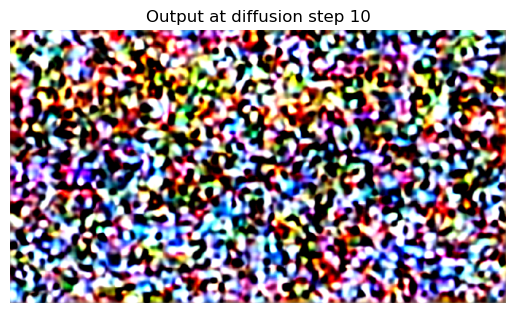

In [4]:
# 6. Visualize the intermediate output.
plt.imshow(noisy_image)
plt.title(f"Output at diffusion step {visualize_dt_timestep}")
plt.axis("off")
plt.show()

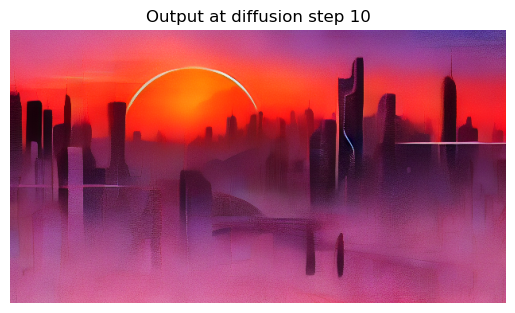

In [5]:
# 6. Visualize the intermediate output.
plt.imshow(intermediate_image)
plt.title(f"Output at diffusion step {visualize_dt_timestep}")
plt.axis("off")
plt.show()